## Log det optimization on SPD manifold

Log det optimization on symmetric positive definite matrices concerns the problem:
$$\min_{\mathbf X \in \mathbb S^{d}_{++}} \frac{1}{n} \sum_{i=1}^n \Big( - \log\det(\mathbf X) + \text{trace}(\mathbf {XC_i}) \Big)$$

with the optimal solution given as $\mathbf X^* = ( \frac{1}{n} \sum_{i=1}^n C_i )^{-1}$

In [ ]:
# !python -m pip install -U pip setuptools

In [7]:
#!pip install git+https://github.com/SaitejaUtpala/rieoptax.git
!pip install git+https://github.com/andyjm3/rieoptax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andyjm3/rieoptax.git to /tmp/pip-req-build-k4jqa9kt
  Running command git clone --filter=blob:none --quiet https://github.com/andyjm3/rieoptax.git /tmp/pip-req-build-k4jqa9kt
  Resolved https://github.com/andyjm3/rieoptax.git to commit 7031785327cf6bfe307529085d069d575cc011de
  Preparing metadata (setup.py) ... done


In [8]:
seed = 42

In [9]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

from timeit import default_timer as timer

from jax.config import config
from jax import jit, vmap
from jax import numpy as jnp
from jax.numpy.linalg import qr, slogdet
from jax import random

config.update("jax_enable_x64", True) # run jax at float64 bit precision

from rieoptax.core import ManifoldArray, rgrad
from rieoptax.geometry.spd import SPDAffineInvariant
from rieoptax.optimizers.first_order import rsgd
from rieoptax.optimizers.update import apply_updates

Generate data

In [17]:
d = 50
CN = 10
n = 10

C = []
for i in range(n):
  D = 1000*jnp.diag(jnp.logspace(-jnp.log10(CN), 0, d))
  key = random.PRNGKey(seed)
  [Q, R] = qr(random.normal(key, shape=(d,d))) 
  Ci = Q @ D @ Q.T
  C.append(jnp.expand_dims(Ci, axis=0))
  
C = jnp.concatenate(C, axis=0)

# compute optimal solution and cost
Xopt = jnp.linalg.matrix_power(jnp.sum(C, axis=0)/n, -1)

logdetXopt = slogdet(Xopt)[1]
costopt = -logdetXopt + jnp.trace(Xopt @ jnp.sum(C, axis=0)/n)

In [18]:
costopt.item()

337.8231366242557

In [39]:
# Xinit
Xinit = jnp.eye(d)

# define fit function
def fit(params, data, optimizer, epochs):
    @jit 
    def step(params, opt_state, data):

        def cost(params, data):
            def _cost(params, data):
                return -slogdet(params.value)[1] + jnp.trace( params.value @ data )
            return vmap(_cost, in_axes=(None,0))(params, data).mean()

        rgrads = rgrad(cost)(params, data) #calculates Riemannian gradients
        updates, opt_state = optimizer.update(rgrads, opt_state, params)
        params = apply_updates(params, updates) #Update using Riemannian Exp
        loss_value = cost(params, data)
        return params, opt_state, loss_value

    opt_state = optimizer.init(params)
    rieoptax_loss = []
    rieoptax_time = []
    start = timer()
    for i in range(epochs):
        params, opt_state, loss_value = step(params, opt_state, data)
        #print(f"iter {i}:", loss_value)
        elapsed_time = timer() - start
        rieoptax_loss.append(loss_value)
        rieoptax_time.append(elapsed_time)


    return rieoptax_loss, rieoptax_time

In [40]:
X_init = ManifoldArray(value=Xinit, manifold=SPDAffineInvariant(d))    
epochs = 200
lr = 1e-3
optimizer = rsgd(lr)
rieoptax_loss, rieoptax_time = fit(X_init, C, optimizer, epochs)

Traced<ShapedArray(float64[50,50])>with<DynamicJaxprTrace(level=0/1)>


In [36]:
rieoptax_loss

[DeviceArray(2018.77336346, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 DeviceArray(nan, dtype=float64),
 Dev

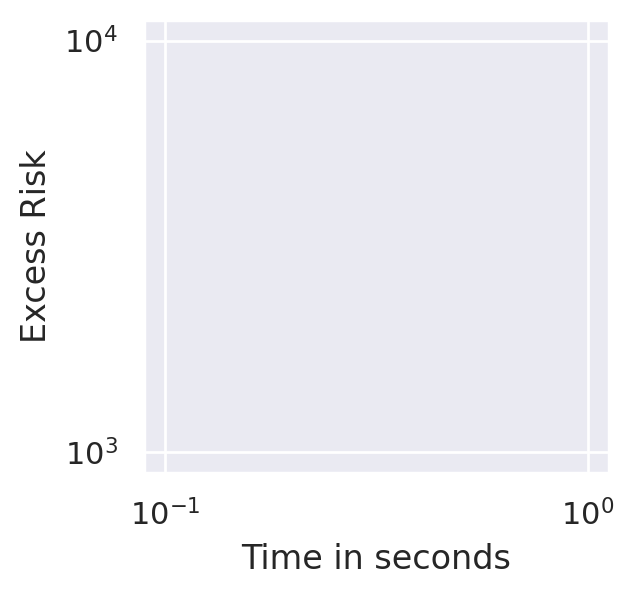

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set_style("darkgrid")


fig, axes = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
axes.plot(jnp.asarray(rieoptax_time),  jnp.asarray(rieoptax_loss) - jnp.asarray(costopt))
axes.set_yscale("log")
axes.set_xscale("log")
axes.set_ylabel("Excess Risk")
axes.set_xlabel("Time in seconds")
plt.show()